In [18]:
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib as mpl
import numpy as np
import pandas as pd
import scipy
import xarray as xr
import seaborn as sns

In [2]:
%matplotlib inline

# Read flux and state variables

In [33]:
def postprocess_vars(tag):
    case_prefix = 'delsa-top6_%s_0.base_'%tag
    archive_dir = '/glade/scratch/elkoukah/archive/'
    prun_list = open('/glade/work/elkoukah/inputs/params/param_ens_ucrb_headwaters/delsa_top6_0/pe_basin_0.main_run.txt',"r")
    run_list = prun_list.read().split('\n')[:-1]
    nitem = len(run_list)
    suffix = '000'
    start_date = "1952-10-01"
    end_date = "2010-09-30"
    tdelta = slice(start_date, end_date)
    areas = {'yampa':1468, 'east':748, 'animas':1819} #km^2
    stids = {'yampa':'09239500', 'east':'09112500', 'animas':'09361500'}
    
    varnames = ['QRUNOFF','QOVER','QDRAI','EFLX_LH_TOT','QSOIL','QVEGE','QVEGT','SNOCAN','H2OSOI','H2OSNO','H2OCAN', 'FSNO', 'SNOW_DEPTH', 'QINFL', 'QINTR', 'QSNOMELT']
    output_var = {var:[] for var in varnames}

    for ii in range(1, nitem+1):
        istr = str(ii)
        s = suffix[:-len(istr)]+istr
        rofdir = archive_dir+case_prefix+s+'/lnd/hist/'
        roffile = rofdir+case_prefix+s+'.clm2.h1.*'
        print(s, 'processing:', roffile)
        dsrof = xr.open_mfdataset(roffile).load()
        da = dsrof.isel(lndgrid=0).sel(time=tdelta)
        for varname in varnames:
            davar = da[varname].resample(time='1M').mean('time')
            output_var[varname].append(davar)
    ds_vars = {}
    for varname in varnames:
        da_var_ens = xr.concat(output_var[varname], dim='pert')
        ds_vars[varname] = da_var_ens
    return ds_vars

tag = 'animas'
ds_vars = postprocess_vars(tag)
ds_vars.to_netcdf('/glade/scratch/elkoukah/archive/pipeline/%s_pertub_delsa_daily_varialbes.nc'%tag)

# Calculate DELSA

In [7]:
# read sample of parameter values
perturbed_param_desla = np.load('/glade/work/elkoukah/inputs/params/param_ens_ucrb_headwaters/delsa_top6_0/delsa_top6_0.npy', allow_pickle=True)

In [8]:
# read upper and lower parameter bounds 
inpara_initfile = '/glade/work/elkoukah/inputs/params/param_ens_ucrb_headwaters/delsa_top6_0/pf_intial_params.pkl'
pf_xb = pickle.load( open( inpara_initfile, "rb" ) )
xlb = pf_xb['xlb']
xub = pf_xb['xub']
para_names = pf_xb['name']
varprior = ((xub-xlb)**2)/12

In [12]:
def calc_delsa(perturbed_param_desla, outvals):
    ninit = 100
    npara = perturbed_param_desla.shape[1]
    pftparams = [5]
    pftidx = 12
    nt = outvals.shape[1]
    deriv = np.zeros((ninit, npara, nt))
    varfir = np.zeros((ninit, npara, nt))
    vartot = np.zeros((ninit, nt))
    delsafirst = np.zeros((ninit, npara, nt))
    for ii in range(ninit):
        for jj in range(npara):
            idx = ninit*(jj+1)+ii
            if jj in pftparams:
                para_vals = np.stack(perturbed_param_desla[:, jj])[:, pftidx]
                jj_varprior = varprior[jj][pftidx]
            else:
                para_vals = np.stack(perturbed_param_desla[:, jj])
                jj_varprior = varprior[jj]
            deriv[ii,jj] = (outvals[idx]-outvals[ii])/(para_vals[idx]-para_vals[ii])
            varfir[ii,jj] = (deriv[ii,jj]**2)*jj_varprior
            vartot[ii] = vartot[ii]+varfir[ii,jj]
            if (jj == npara-1):
                delsafirst[ii,:] =  varfir[ii,:]/vartot[ii]
    return delsafirst, vartot

In [10]:
nl = perturbed_param_desla.shape[0]
varnames = ['QRUNOFF','QOVER','QDRAI','EFLX_LH_TOT','QSOIL','QVEGE','QVEGT','SNOCAN','H2OSOI','H2OSNO','H2OCAN', 'FSNO', 'SNOW_DEPTH', 'QINFL', 'QINTR', 'QSNOMELT']

In [98]:
delsa_vars_dd = {}
delsa_vars_dd_vartot = {}

for tag in ['yampa', 'east', 'animas']:
    wfile = '/glade/scratch/elkoukah/archive/pipeline/%s_pertub_delsa_daily_varialbes.nc'%tag
    dsout = xr.open_dataset(wfile)
    
    levsoi = dsout.levsoi.data
    thickness = levsoi-np.append([0.],levsoi)[:-1]
    weights = xr.DataArray(thickness, dims='weights')
    
    tmp_vars_dd = {}
    tmp_vars_dd_var = {}
    for varname in varnames:
        davar = dsout[varname].data
        if varname=='H2OSOI':
            sm = davar[:,:,:9]
            wg = weights[:9]
            davar = np.sum(sm.data*wg.data, axis=-1)/np.sum(wg.data)
        delsafirst, vartot = calc_delsa(perturbed_param_desla, davar)
        tmp_vars_dd[varname] = delsafirst
        tmp_vars_dd_var[varname] = vartot
        print(tag, varname, 'daily sensitivity')
    delsa_vars_dd[tag] = tmp_vars_dd
    delsa_vars_dd_vartot[tag] = tmp_vars_dd_wmean

/glade/scratch/elkoukah/ipykernel_72287/1988563263.py:53: RuntimeWarning: invalid value encountered in divide
  delsafirst[ii,:] =  varfir[ii,:]/vartot[ii]


yampa QRUNOFF daily sensitivity
yampa QOVER daily sensitivity
yampa QDRAI daily sensitivity
yampa EFLX_LH_TOT daily sensitivity
yampa QSOIL daily sensitivity
yampa QVEGE daily sensitivity
yampa QVEGT daily sensitivity
yampa SNOCAN daily sensitivity
yampa H2OSOI daily sensitivity
yampa H2OSNO daily sensitivity
yampa H2OCAN daily sensitivity
yampa FSNO daily sensitivity
yampa SNOW_DEPTH daily sensitivity
yampa QINFL daily sensitivity
yampa QINTR daily sensitivity
yampa QSNOMELT daily sensitivity
east QRUNOFF daily sensitivity
east QOVER daily sensitivity
east QDRAI daily sensitivity
east EFLX_LH_TOT daily sensitivity
east QSOIL daily sensitivity
east QVEGE daily sensitivity
east QVEGT daily sensitivity
east SNOCAN daily sensitivity
east H2OSOI daily sensitivity
east H2OSNO daily sensitivity
east H2OCAN daily sensitivity
east FSNO daily sensitivity
east SNOW_DEPTH daily sensitivity
east QINFL daily sensitivity
east QINTR daily sensitivity
east QSNOMELT daily sensitivity
animas QRUNOFF dai

In [310]:
delsa_outputs = dict(
delsa_vars_dd = delsa_vars_dd,
delsa_vars_dd_vartot = delsa_vars_dd_vartot,
)
wfile = '/glade/work/elkoukah/inputs/params/param_ens_ucrb_headwaters/delsa_top6_0/delsa_outputs.pkl'
pickle.dump( delsa_outputs, open( wfile, "wb" ) )

In [11]:
# If already calculated delsa

In [13]:
wfile = '/glade/work/elkoukah/inputs/params/param_ens_ucrb_headwaters/delsa_top6_0/delsa_outputs.pkl'
delsa_outputs = pickle.load( open( wfile, "rb" ) )

In [14]:
delsa_vars_dd = delsa_outputs['delsa_vars_dd']
delsa_vars_dd_wmean = delsa_outputs['delsa_vars_dd_wmean']

# Figures

In [ ]:
# Cumulative frequency

In [16]:
selected_params = ['fff', 'medlynintercept', 'frac_sat_soil_dsl_init', 'd_max', 'watsat_sf', 'bsw_sf']
basins = ['yampa', 'east', 'animas']
reorder_params_idx = [4,5,1,0,3,2]

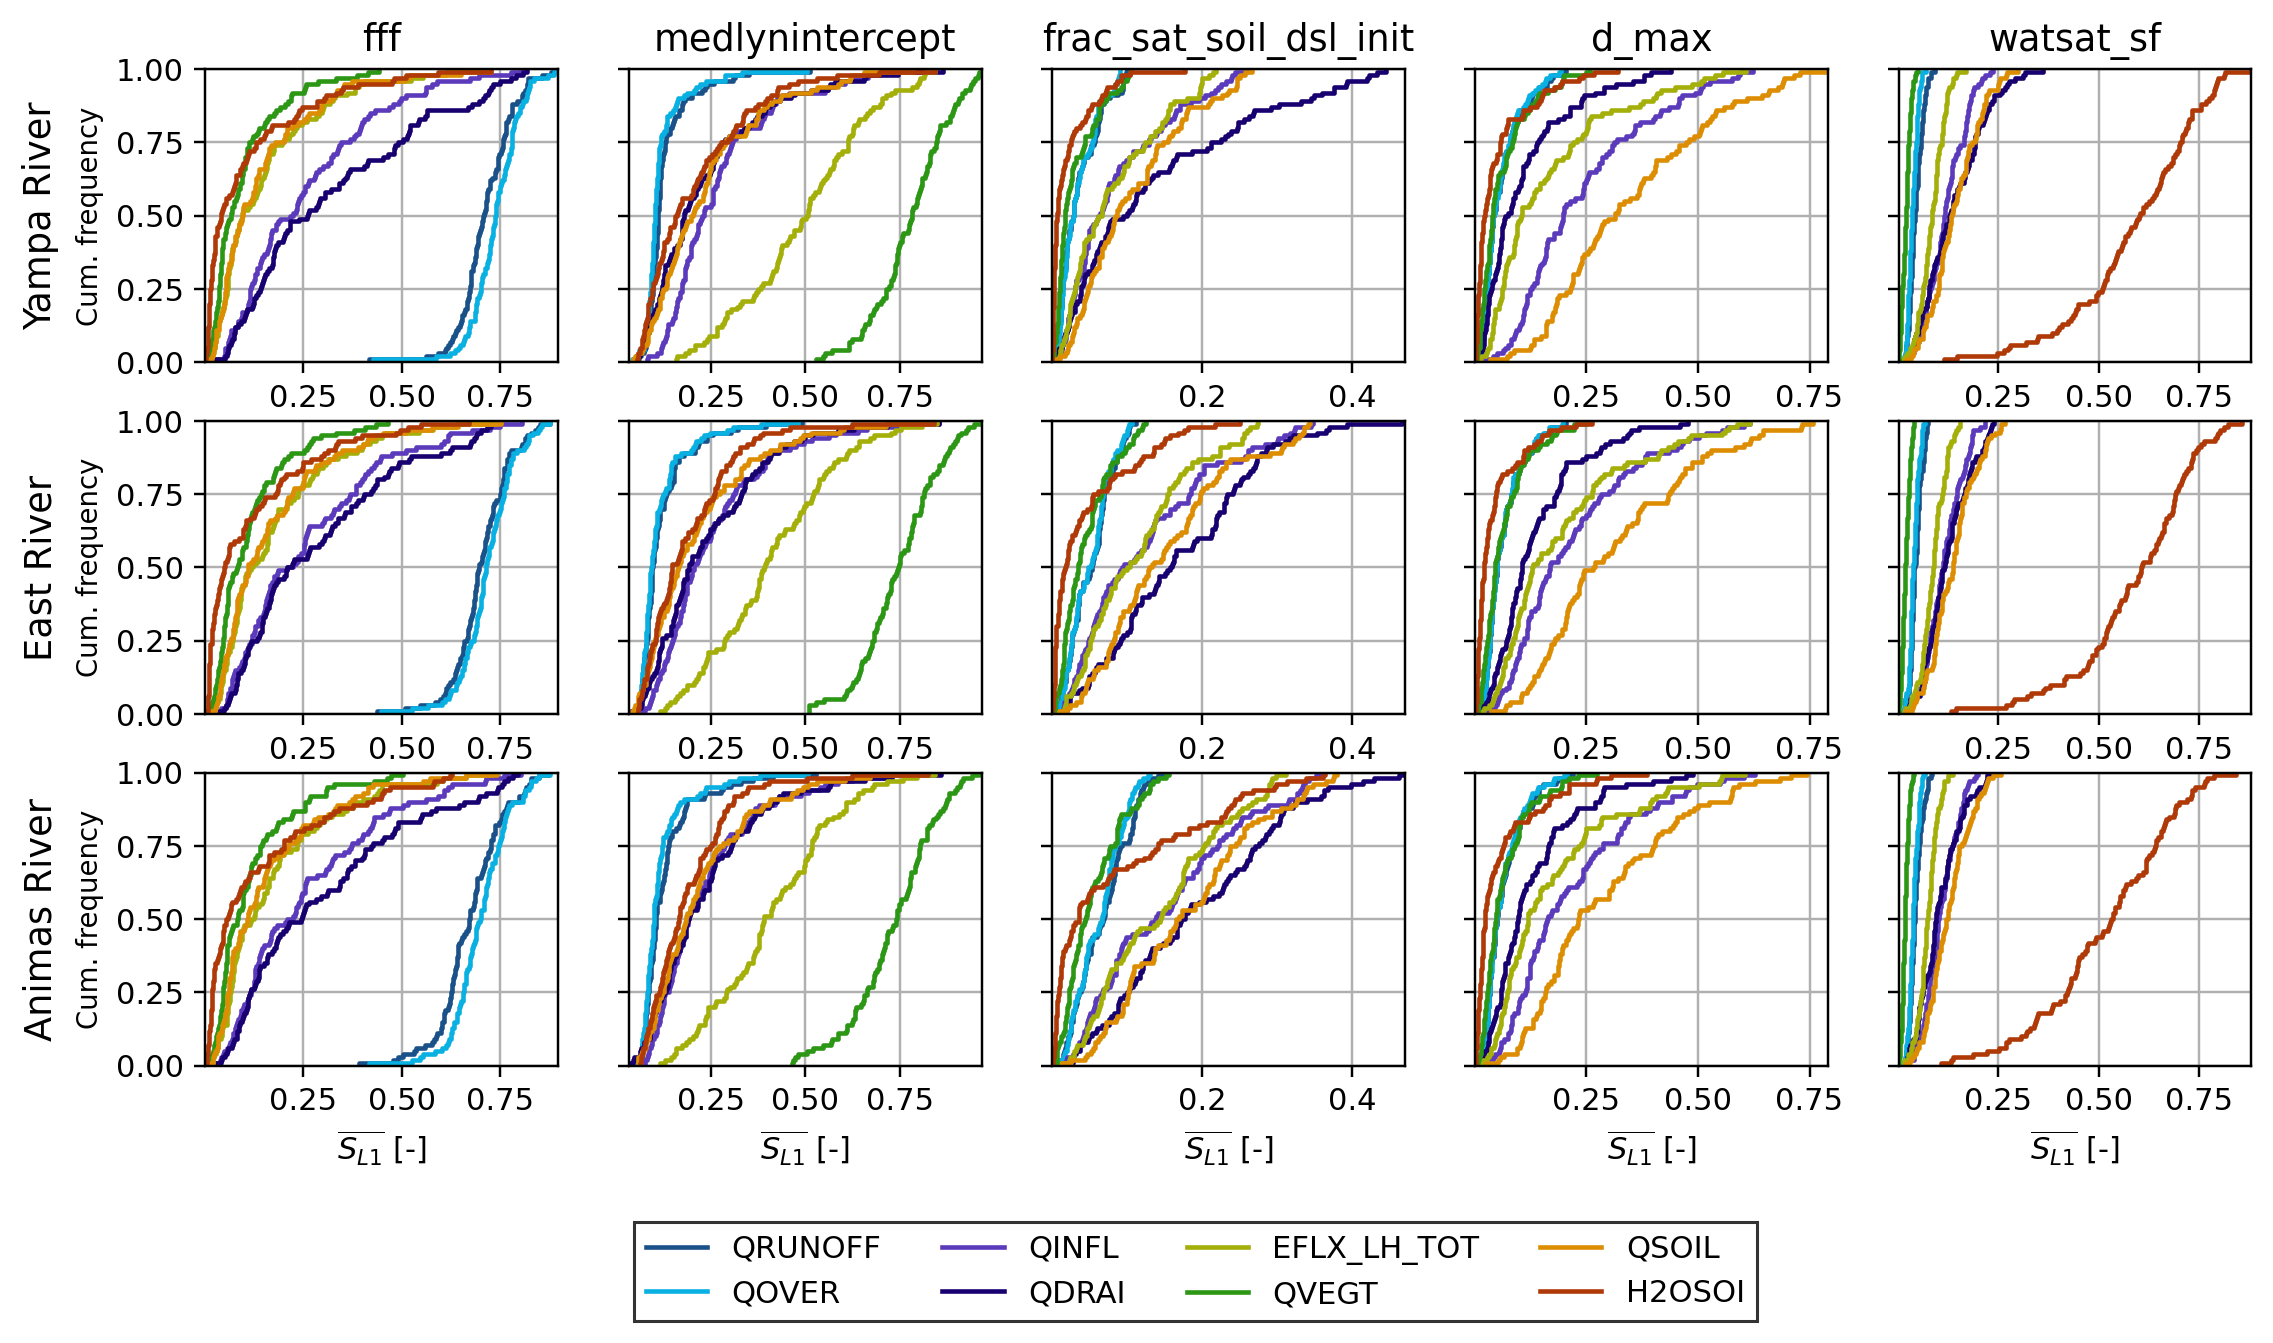

In [20]:
fig, axes = plt.subplots(3,5,figsize=(12,6), dpi=220, sharey='row', sharex='col')

vars_list = ['QRUNOFF','QOVER','QINFL', 'QDRAI', 
             'EFLX_LH_TOT', 'QVEGT', 'QSOIL',
             'H2OSOI']
colors = ['#1a5189','#09b0e2', '#5b3abc', '#180070',
          '#a4af0a','#2c9615','#dd8d02',
          '#af3a08']
for bii in range(3):
    tag = basins[bii]
    for pii in range(5):
        ax = axes[bii, pii]
        for vii, var in enumerate(vars_list):
            data = np.nanmean(delsa_vars_dd[tag][var], axis=-1)
            cdfplot = sns.ecdfplot(x=data[:, reorder_params_idx][:, pii], stat='proportion', legend=False, ax=ax, color=colors[vii])
        if bii==0:
            ax.set_title(selected_params[pii])
        if bii==2:
            ax.set_xlabel(r'$\overline{S_{L1}}$ [-]')
        if pii==0:
            ax.set_ylabel('Cum. frequency', fontsize=9)
        ax.margins(x=0)
        ax.xaxis.set_tick_params(which='both', labelbottom=True)
        ax.grid()
titles = ['Yampa River', 'East River', 'Animas River']
ax1,ax2,ax3 = axes[:, 0]
ax1.annotate(titles[0], (-0.52,0.5), xycoords='axes fraction', fontsize=12, rotation=90, verticalalignment='center')
ax2.annotate(titles[1], (-0.52,0.5), xycoords='axes fraction', fontsize=12, rotation=90, verticalalignment='center')
ax3.annotate(titles[2], (-0.52,0.5), xycoords='axes fraction', fontsize=12, rotation=90, verticalalignment='center')
fig.legend(ax.lines, vars_list, frameon=True, fancybox=False, ncol=4, bbox_to_anchor=(0.5,-0.08), edgecolor='k', loc='lower center')

In [21]:
## Timeseries

In [23]:
# AREA above CDF
def trapezoidal(sens,a=0,b=1,h=0.01,n=100):
    nt = sens.shape[1]
    I_trap = np.zeros((nt,))
    for ii in range(nt):
        f, it = np.histogram(sens[:, ii], bins=n, range=(0,1), density=True)
        f = np.cumsum(f)/(n-1)
        I_trap[ii] = (h/2)*(f[0] + 2 * np.sum(f[1:n-1],axis=0) + f[n-1])
    return I_trap

In [27]:
# Read daily flux variables
dict_dsouts = {}
for tag in ['yampa', 'east', 'animas']:
    wfile = '/glade/scratch/elkoukah/archive/pipeline/%s_pertub_delsa_daily_varialbes.nc'%tag
    dsout = xr.open_dataset(wfile)
    dict_dsouts[tag] = dsout

varda = dict_dsouts[tag][varname]
da_flx = varda.mean('pert')*24*60**2
time = da_flx.time.astype("datetime64[ns]")
da_var = np.std(varda*24*60**2, axis=0)**2

In [30]:
# Plot
def ax_plot_sens(sens, da_flx, da_var, ma, time, tag, varname, ax, title, ti=365*32, te=365*34, ylabel_1='F (mm d$^{-1}$)', ylabel_2='V (mm d$^{-1}$)'):
    sens_cdf = 1-trapezoidal(sens)
    sens_cdf[ma] = 0
    twin1 = ax.twinx()
    twin2 = ax.twinx()
    twin2.spines.right.set_position(("axes", 1.1))
    p1, = twin1.plot(time[ti:te], da_flx.data[ti:te], c='tab:blue')
    p2, = ax.plot(time[ti:te], sens_cdf[ti:te], c='grey', )
    p3, = twin2.plot(time[ti:te], da_var[ti:te], c='k', ls='--',)
    plt.title(title)
    twin1.set_ylabel(ylabel_1)
    twin2.set_ylabel(ylabel_2)
    ax.set_ylabel('IS$_{L1}$ (-)')

    ax.yaxis.label.set_color(p2.get_color())
    twin1.yaxis.label.set_color(p1.get_color())
    twin2.yaxis.label.set_color(p3.get_color())

    ax.tick_params(axis='y', colors=p2.get_color())
    twin1.tick_params(axis='y', colors=p1.get_color())
    twin2.tick_params(axis='y', colors=p3.get_color())
    
    ax.margins(x=0, y=0.0)
    twin1.margins(x=0, y=0.0)
    twin2.margins(x=0, y=0.0)
    
    ax.tick_params(axis='x', rotation=45, length=6)
    return ax

In [29]:
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

Text(-0.02, 1.05, '$\\bf{f}$')

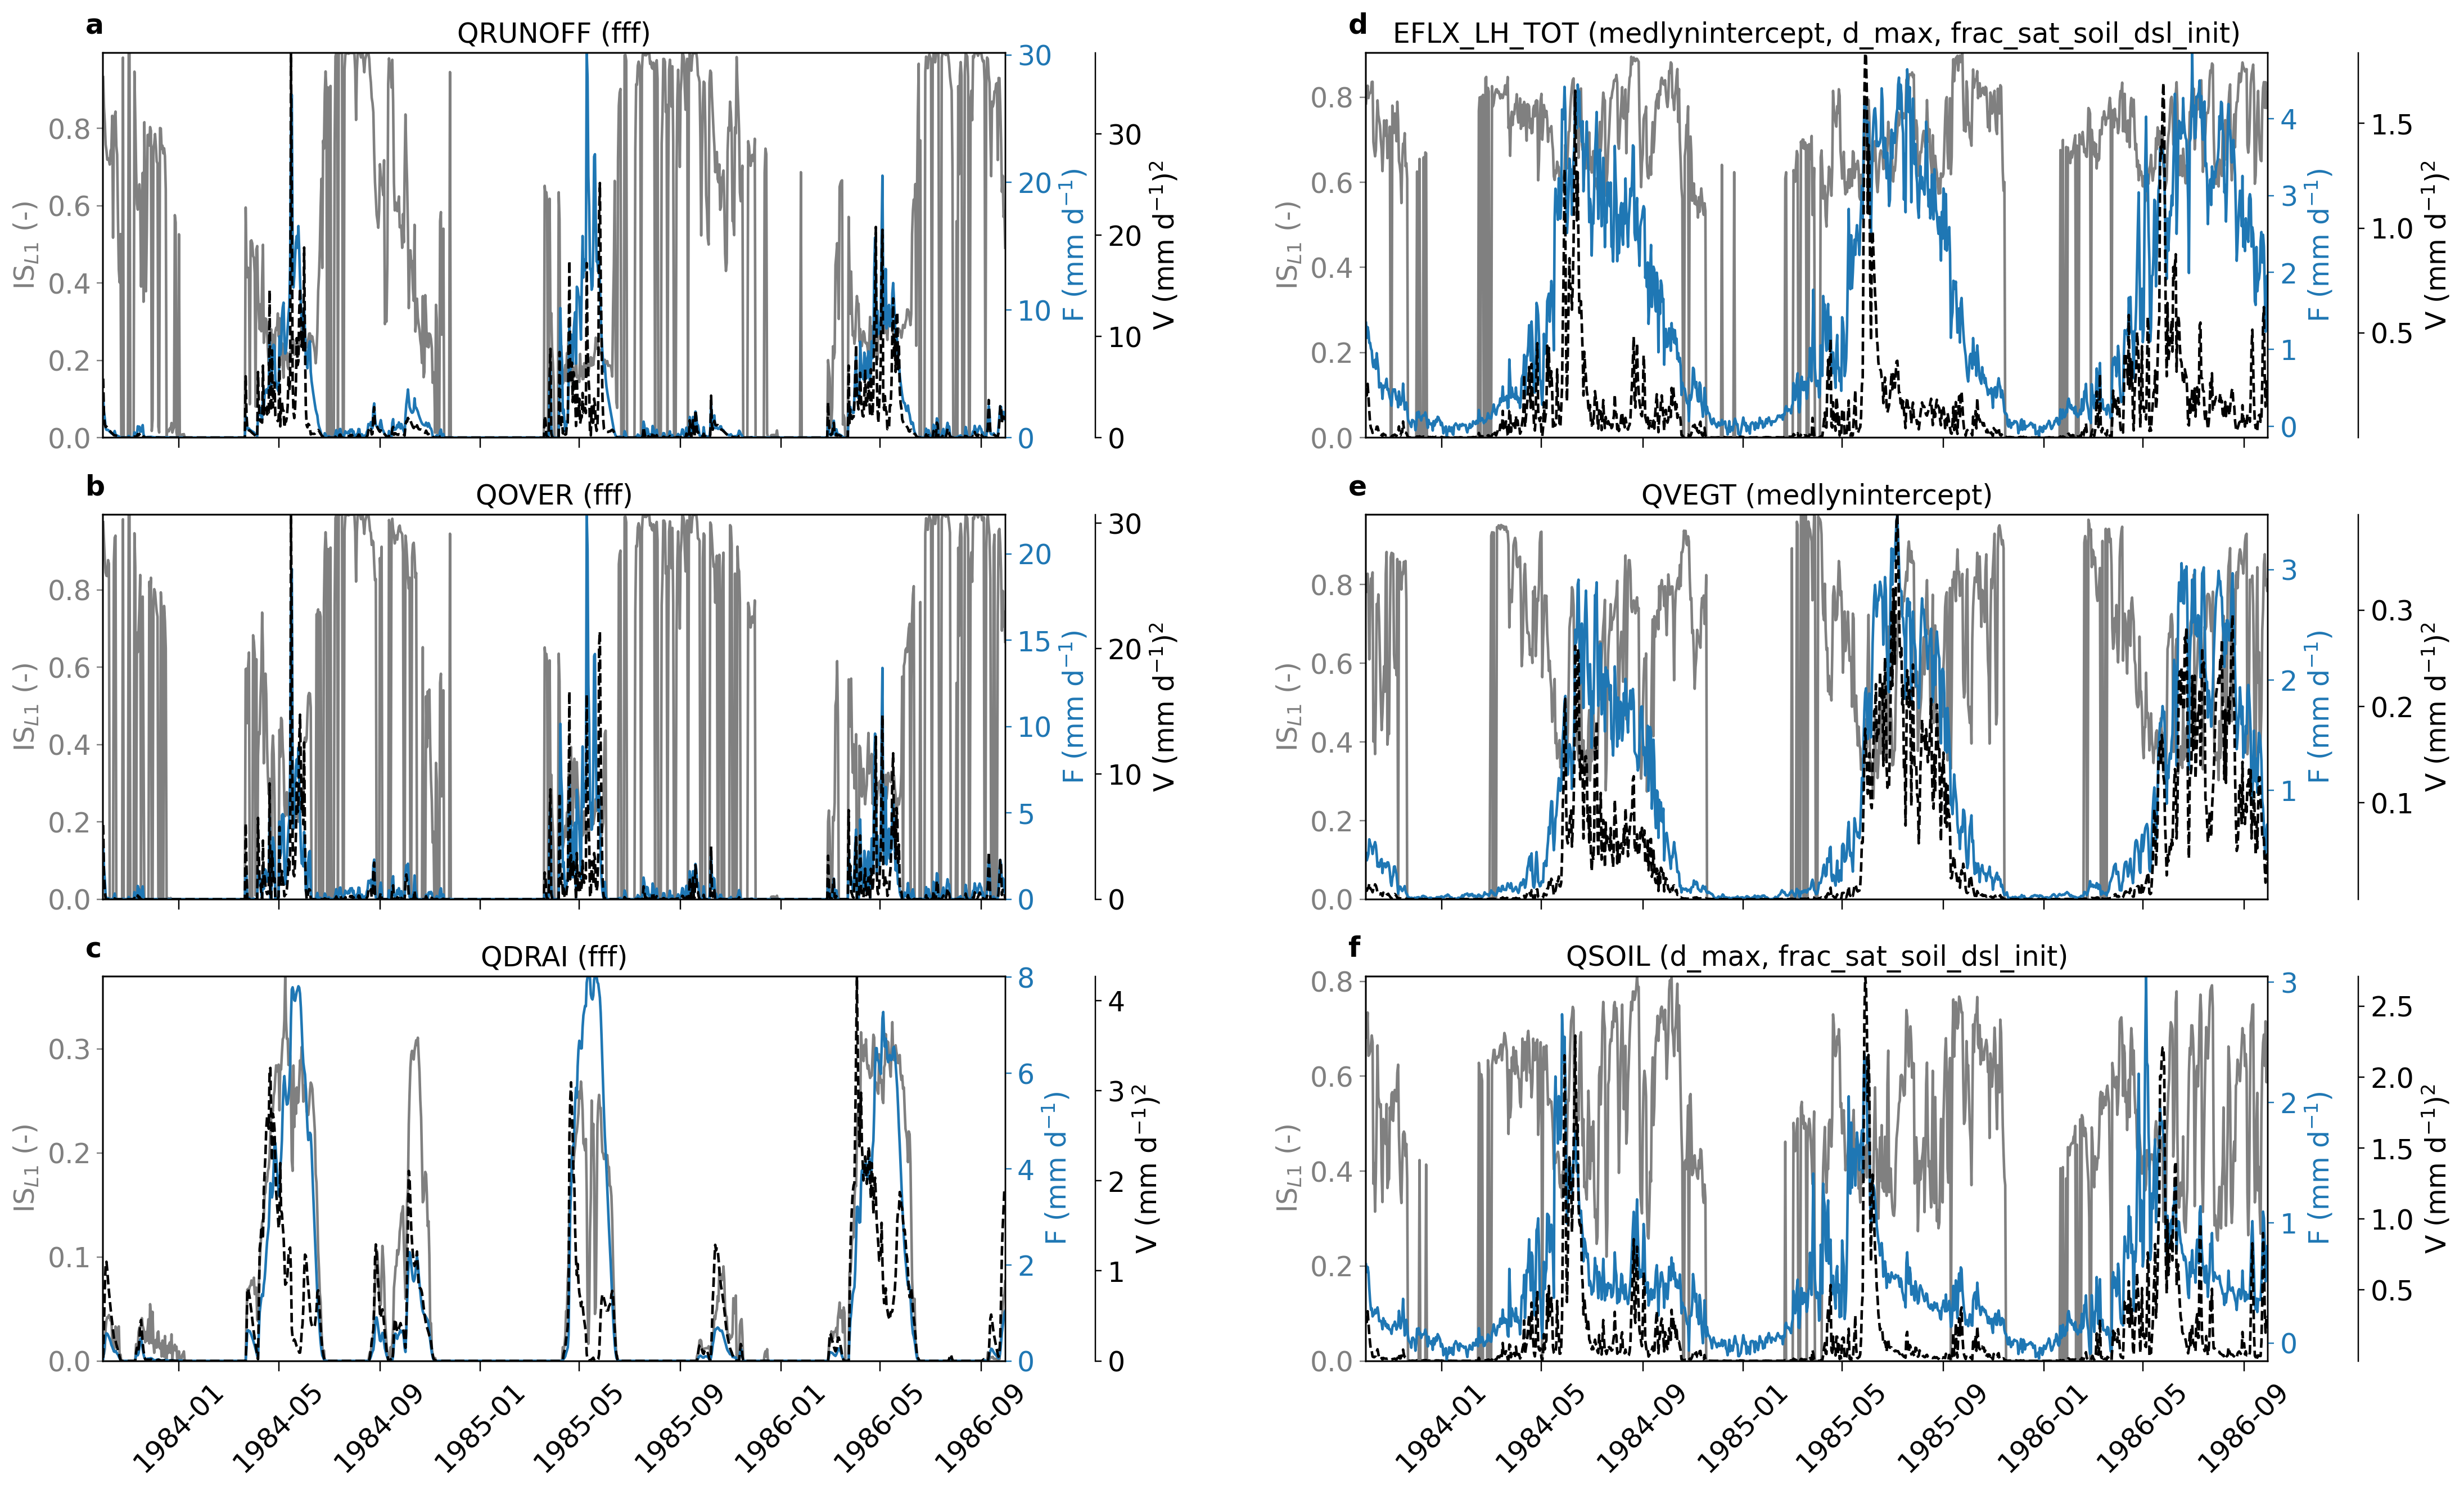

In [31]:
tag = 'animas'

fig, axes = plt.subplots(3,2, figsize=(28,14), sharex='col', dpi=220, gridspec_kw={'wspace':.4})
fig.subplots_adjust(right=0.75)

ti = 365*32
te = 365*35


for ii,varname in enumerate(['QRUNOFF','QOVER','QDRAI']):
    varda = dict_dsouts[tag][varname]
    da_flx = varda.mean('pert')*24*60**2
    time = da_flx.time.astype("datetime64[ns]")
    da_var = np.std(varda*24*60**2, axis=0)**2
    ma = (np.round(da_var, decimals=3)==0)
    delsafirst_fill = np.where(np.isnan(delsa_vars_dd[tag][varname]), 0, delsa_vars_dd[tag][varname])
    sens = delsafirst_fill[:, 4]

    ax = axes[ii, 0]
    ax_plot_sens(sens, da_flx, da_var, ma, time, tag, varname, ax, varname+' (fff)', ti=ti, te=te, ylabel_1='F (mm d$^{-1}$)', ylabel_2='V (mm d$^{-1}$)$^{2}$')    

for ii,varname in enumerate(['EFLX_LH_TOT']):
    varda = dict_dsouts[tag][varname]/(2.45*10**6) * 24*60**2
    da_flx = varda.mean('pert')
    time = da_flx.time.astype("datetime64[ns]")
    da_var = np.std(varda, axis=0)**2
    ma = (np.round(da_var, decimals=2)==0)
    delsafirst_fill = np.where(np.isnan(delsa_vars_dd[tag][varname]), 0, delsa_vars_dd[tag][varname])
    sens = delsafirst_fill[:,0]+delsafirst_fill[:,1]+delsafirst_fill[:,5]
    
    ax = axes[0,1]
    ax_plot_sens(sens, da_flx, da_var, ma, time, tag, varname, ax, varname+' (medlynintercept, d_max, frac_sat_soil_dsl_init)', 
                 ti=ti, te=te, ylabel_1='F (mm d$^{-1}$)', ylabel_2='V (mm d$^{-1}$)$^{2}$')

for ii,varname in enumerate(['QVEGT']):
    
    varda = dict_dsouts[tag][varname]
    da_flx = varda.mean('pert')*24*60**2
    time = da_flx.time.astype("datetime64[ns]")
    da_var = np.std(varda*24*60**2, axis=0)**2
    ma = (np.round(da_var, decimals=3)==0)
    delsafirst_fill = np.where(np.isnan(delsa_vars_dd[tag][varname]), 0, delsa_vars_dd[tag][varname])
    sens = delsafirst_fill[:,5]
    
    ax = axes[1,1]
    ax_plot_sens(sens, da_flx, da_var, ma, time, tag, varname, ax, varname+' (medlynintercept)', ti=ti, te=te, ylabel_1='F (mm d$^{-1}$)', ylabel_2='V (mm d$^{-1}$)$^{2}$')

for ii,varname in enumerate(['QSOIL']):
    
    varda = dict_dsouts[tag][varname]
    da_flx = varda.mean('pert')*24*60**2
    time = da_flx.time.astype("datetime64[ns]")
    da_var = np.std(varda*24*60**2, axis=0)**2
    ma = (np.round(da_var, decimals=2)==0)
    delsafirst_fill = np.where(np.isnan(delsa_vars_dd[tag][varname]), 0, delsa_vars_dd[tag][varname])
    sens = delsafirst_fill[:,0]+delsafirst_fill[:,1]
    
    ax = axes[2,1]
    ax_plot_sens(sens, da_flx, da_var, ma, time, tag, varname, ax, varname+' (d_max, frac_sat_soil_dsl_init)', ti=ti, te=te, ylabel_1='F (mm d$^{-1}$)', ylabel_2='V (mm d$^{-1}$)$^{2}$')

axes[0,0].annotate(r'$\bf{a}$', (-0.02,1.05), xycoords='axes fraction', fontsize=16)
axes[1,0].annotate(r'$\bf{b}$', (-0.02,1.05), xycoords='axes fraction', fontsize=16)
axes[2,0].annotate(r'$\bf{c}$', (-0.02,1.05), xycoords='axes fraction', fontsize=16)

axes[0,1].annotate(r'$\bf{d}$', (-0.02,1.05), xycoords='axes fraction', fontsize=16)
axes[1,1].annotate(r'$\bf{e}$', (-0.02,1.05), xycoords='axes fraction', fontsize=16)
axes[2,1].annotate(r'$\bf{f}$', (-0.02,1.05), xycoords='axes fraction', fontsize=16)

# fig.savefig('figs_delsa_analysis/animas_timeseries_integrated_sensitivities.jpg')